<a href="https://colab.research.google.com/github/cmfritz/capstone/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import packages
import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk

from nltk import FreqDist, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, recall_score
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# import my custom library into colab
import sys
sys.path.append('/content/gdrive/MyDrive/Github/capstone/')
import mylibrary as mylib

Mounted at /content/gdrive


In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
%cd /content/gdrive/My Drive/Github/capstone

/content/gdrive/My Drive/Github/capstone


In [5]:
df = pd.read_pickle('data/data_4_analysis.pkl')

In [6]:
df_master = df[df.sector!='Other fields']
df_master

,patent_id,sector,text
0,10001059,Mechanical engineering,1. A method of removing a tower shaft of a gas...
1,10189524,Mechanical engineering,"1. A two-wheeled vehicle, comprising: a frame ..."
2,10309306,Mechanical engineering,1. A turbofan engine comprising: a fan rotatab...
3,10427924,Mechanical engineering,1. An industrial truck comprising: a mast; a l...
4,10428949,Mechanical engineering,1. A header ring comprising: an opening; a rad...
...,...,...,...
2265879,10800649,Chemistry,1. A microelectromechanical systems (MEMS) dev...
2265880,10800650,Chemistry,1. A semiconductor device comprising: a cavity...
2265881,10807862,Chemistry,"1. A semiconductor device, comprising: a semic..."
2265882,10807863,Chemistry,1. A method for manufacturing micromechanical ...


In [7]:
# truncate data for testing purposes
df = df_master[:int(len(df_master.patent_id)*0.2)]
df

,patent_id,sector,text
0,10001059,Mechanical engineering,1. A method of removing a tower shaft of a gas...
1,10189524,Mechanical engineering,"1. A two-wheeled vehicle, comprising: a frame ..."
2,10309306,Mechanical engineering,1. A turbofan engine comprising: a fan rotatab...
3,10427924,Mechanical engineering,1. An industrial truck comprising: a mast; a l...
4,10428949,Mechanical engineering,1. A header ring comprising: an opening; a rad...
...,...,...,...
431728,9628646,Electrical engineering,1. An augmented reality operation system compr...
431729,9628648,Electrical engineering,1. A printing apparatus comprising: a receiver...
431730,9628659,Electrical engineering,1. A method for inspecting an object in a fiel...
431731,9628660,Electrical engineering,"1. A method of recognizing a document image, t..."


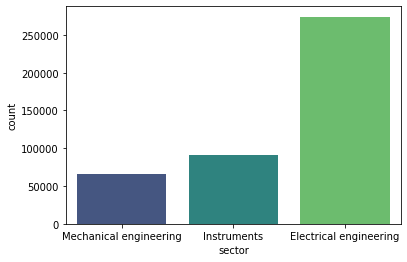

In [8]:
# Look at the counts for each category
ax = sns.countplot(x='sector', data=df, palette='viridis')

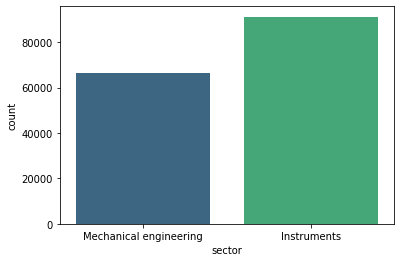

In [9]:
# drop large sectors
df = df[df.sector != 'Electrical engineering'] # Deal with EE later
df = df[df.sector != 'Chemistry']
ax = sns.countplot(x='sector', data=df, palette='viridis')

In [10]:
y = df['sector']
X = df['text']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
y_train.to_pickle('data/y_train.pkl')
y_test.to_pickle('data/y_test.pkl')

In [12]:
def tokenize(text):
    # text = ''.join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [13]:
# make nltk stoplist
# can add extra features like year, length of document, avg length of words, etc.
# TFIDF vectorizer instead of CountVectorizer

In [14]:
# vec = CountVectorizer(ngram_range=(1,3),
#                       tokenizer=tokenize, 
#                       stop_words='english')

In [15]:
stop_words = stopwords.words('english')
custom_stops = ['claim', 'claims', 'method', 'comprising', 'comprises', 'including', 'includes', 'according']
[stop_words.append(word) for word in custom_stops]
stop_words[-10:]

['wouldn',
 "wouldn't",
 'claim',
 'claims',
 'method',
 'comprising',
 'comprises',
 'including',
 'includes',
 'according']

In [16]:
vec = TfidfVectorizer(ngram_range=(1,3),
                      stop_words=stop_words,
                      min_df=0.1,
                      max_df=0.9)

In [17]:
X_train_transformed = vec.fit_transform(X_train)
X_train = pd.DataFrame(X_train_transformed.toarray(), columns = vec.get_feature_names())
X_train.to_pickle('data/X_train.pkl')

X_test_transformed = vec.transform(X_test)
X_test = pd.DataFrame(X_test_transformed.toarray(), columns = vec.get_feature_names())
X_test.to_pickle('data/X_test.pkl')

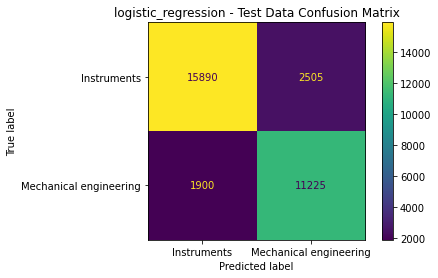

In [21]:
# Initiate the model
logreg = LogisticRegression(random_state=42, n_jobs=1)

# Train and evaluate model
logreg_scores = mylib.model_scores(logreg, 'logistic_regression',
                                   X_train, X_test, 
                                   y_train, y_test)

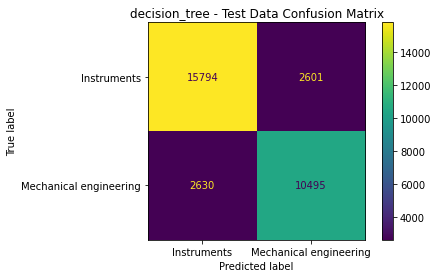

In [25]:
# Initiate the model
dt = DecisionTreeClassifier(random_state=42)  

# Train and evaluate model
dt_scores = mylib.model_scores(dt, 'decision_tree',
                                   X_train, X_test, 
                                   y_train, y_test)

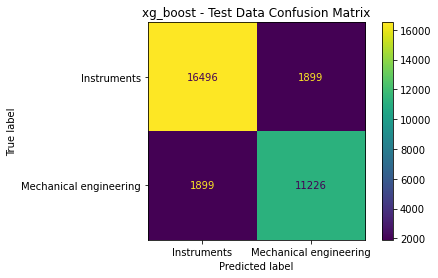

In [24]:
# Initiate the model
xgb = XGBClassifier(random_state=42)

# Train and evaluate model
xgb_scores = mylib.model_scores(xgb, 'xg_boost',
                                   X_train, X_test, 
                                   y_train, y_test)

In [27]:
scores = pd.concat([logreg_scores, dt_scores, xgb_scores])
scores

,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
logistic_regression,0.858086,0.860247,0.863074,0.863822,0.875352,0.878264
decision_tree,0.998533,0.834042,0.999684,0.858603,0.998730,0.857927
xg_boost,0.877859,0.879505,0.894300,0.896765,0.894233,0.896765


Text(0.5, 1.0, 'Feature Importance Top 20 - Logistic Regression')

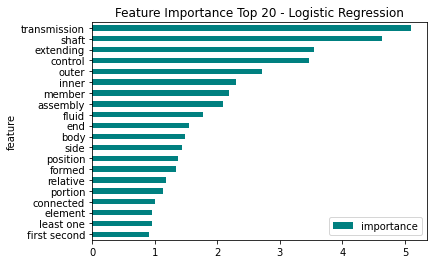

In [31]:
# get importance
feature_names = X_train.columns

# create dataframe of top features
feature_importance = pd.DataFrame(feature_names, columns = ['feature'])
feature_importance['importance'] = logreg.coef_[0]
feature_importance = feature_importance.sort_values(by = ['importance'], ascending=False)

# plot importance
n = 20
ax = feature_importance.iloc[:n].plot.barh(x='feature', y='importance', color='teal').invert_yaxis()
plt.title(f'Feature Importance Top {n} - Logistic Regression')

In [ ]:
def run_grid_search(params, model, X_train, y_train):
    '''
    Takes in parameters, model, and test train data, runs grid search, and 
    returns updated model and test train data.
    
    Parameters: 
    params: dict with parameters for grid search
    model: object containing initialized model for training
    Xy: object containing train and test data for X and y sets
    
    Returns:
    gs: object containing updated model
    Xy: object with test train data
    '''
    gs = GridSearchCV(model, params, scoring='f1_macro', cv=None, n_jobs=1)
    gs = gs.fit(X_train, y_train)
    best_parameters = gs.best_params_

    print('Grid Search found the following optimal parameters: ')
    for param_name in sorted(best_parameters.keys()):
        print('%s: %r' % (param_name, best_parameters[param_name]))

    # Make predictions for test data
    y_hat_train = gs.predict(X_train)
    
    # Make predictions for test data
    y_hat_test = gs.predict(X_test)
    
    return gs, y_hat_train, y_hat_test

In [ ]:
# define parameters to search
params_dt = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(6,10),
    'min_samples_split':range(6,10),
    'min_samples_leaf':range(3,5)
    }

# run grid search
dt, y_hat_train, y_hat_test = run_grid_search(params_dt, dt, X_train, y_train)

# Evaluate model
model_scores(dt, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)

Grid Search found the following optimal parameters: 
booster: 'gbtree'
max_delta_step : 10
max_depth: 8
n_estimators: 50
Training Accuracy: 89.14%
Test Accuracy: 88.29%

Training Recall Score: 90.09%
Test Recall Score: 89.5%

Training F1 Score: 90.55%
Test F1 Score: 89.92%

Confusion Matrix for test data


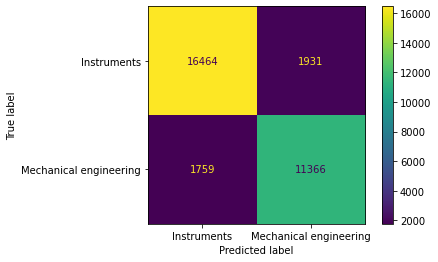

In [ ]:
# define parameters to search
params_xgb = {
    'booster':['gbtree', 'gblinear', 'dart'],
    'max_delta_step ':[100, 10, 1, 0.1],
    'max_depth':8
    }

# run grid search
dt, y_hat_train, y_hat_test = run_grid_search(params_xgb, xgb, X_train, y_train)

# Evaluate model
model_scores(dt, 
             X_train, X_test, 
             y_train, y_test, 
             y_hat_train, y_hat_test)